In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)
from keras.models import Model, Sequential
from keras.layers import Dense, Input, LSTM, Dropout
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyFTS.benchmarks import Measures
import statistics
from pyFTS.common.Util import persist_obj, load_obj
from pyFTS.models.multivariate import common, variable, wmvfts
from pyFTS.partitioners import Grid
from pyFTS.common import Membership
import math
import pyFTS
import datetime
from pyFTS.common import Util

In [3]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [4]:
# To get reproducible results with Keras
from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)
import tensorflow
tensorflow.random.set_seed(2)

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [11]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var='Appliances', dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [('Appliances(t)')]
		else:
			names += [('Appliances(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [12]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2','T9','T6','Windspeed'], axis=1)
values = data.values
values

array([[ 60.        ,  30.        ,  19.89      , ...,  92.        ,
         63.        ,   5.3       ],
       [ 60.        ,  30.        ,  19.89      , ...,  92.        ,
         59.16666667,   5.2       ],
       [ 50.        ,  30.        ,  19.89      , ...,  92.        ,
         55.33333333,   5.1       ],
       ...,
       [270.        ,  10.        ,  25.5       , ...,  56.33333333,
         25.33333333,  13.26666667],
       [420.        ,  10.        ,  25.5       , ...,  56.66666667,
         26.16666667,  13.23333333],
       [430.        ,  10.        ,  25.5       , ...,  57.        ,
         27.        ,  13.2       ]])

In [13]:
data.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'RH_9',
       'T_out', 'Press_mm_hg', 'RH_out', 'Visibility', 'Tdewpoint'],
      dtype='object')

In [14]:
len(data.columns)

23

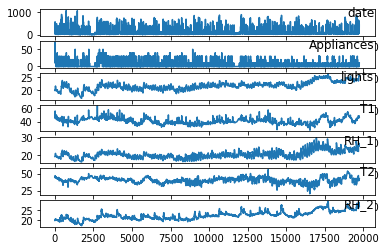

In [15]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
pyplot.close('all')

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled = pd.DataFrame(scaled,columns = list(data.columns))
# frame as supervised learning
reframed = series_to_supervised_miso(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
#reframed.drop(reframed.columns[[0,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]], axis=1, inplace=True)
reframed.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_7(t-1),T8(t-1),RH_8(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.653428,0.173329,0.661412,0.677290,0.372990,0.097674,0.894737,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.651064,0.173329,0.660155,0.678532,0.369239,0.100000,0.894737,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.646572,0.173329,0.655586,0.676049,0.365488,0.102326,0.894737,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.641489,0.164175,0.650788,0.671909,0.361736,0.104651,0.894737,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.639362,0.164175,0.650788,0.671909,0.357985,0.106977,0.894737,0.717949,0.520362,0.037383


In [19]:
len(reframed.values)

19734

In [20]:
values = reframed.values
train_size=int(len(values) *0.75)
test_size = int(len(values)) - train_size
print(test_size)

4934


In [21]:
# split into train and test sets
train_X, train_y = values[:train_size], values[:train_size]
test_X, test_y = values[train_size:], values[train_size:]

# split into input (all columns exceptc last one) and outputs (last column)
train_X, train_y = train_X[:, :-1], train_y[:, -1]
test_X, test_y = test_X[:, :-1], test_y[:, -1]

# reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14800, 1, 23) (14800,) (4934, 1, 23) (4934,)


In [22]:
train_y

array([0.04672897, 0.03738318, 0.03738318, ..., 0.27102804, 0.27102804,
       0.25233645])

In [26]:
# design network
neurons = 50
batch_size = 10
epochs = 500
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [27]:
 model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                14800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 14,851
Trainable params: 14,851
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
1480/1480 [==============================] - 9s 5ms/step - loss: 0.0118 - val_loss: 0.0042
Epoch 2/500
1480/1480 [==============================] - 9s 6ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 3/500
1480/1480 [==============================] - 8s 5ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 4/500
1480/1480 [==============================] - 7s 4ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 5/500
1480/1480 [==============================] - 8s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 6/500
1480/1480 [==============================] - 8s 5ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 7/500
1480/1480 [==============================] - 7s 5ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 8/500
1480/1480 [==============================] - 8s 5ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 9/500
1480/1480 [==============================] - 8s 5ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 10/500
1480/1480 [==============================] - 7s 5ms/step - l

Epoch 80/500
1480/1480 [==============================] - 7s 5ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 81/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 82/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 83/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 84/500
1480/1480 [==============================] - 5s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 85/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 86/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 87/500
1480/1480 [==============================] - 7s 5ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 88/500
1480/1480 [==============================] - 9s 6ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 89/500
1480/1480 [==============================] - 8s 6ms

1480/1480 [==============================] - 4s 3ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 159/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 160/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 161/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 162/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 163/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 164/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 165/500
1480/1480 [==============================] - 5s 4ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 166/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 167/500
1480/1480 [==============================] - 5s 3ms/ste

1480/1480 [==============================] - 4s 3ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 237/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 238/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 239/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 240/500
1480/1480 [==============================] - 5s 4ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 241/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 242/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 243/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 244/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 245/500
1480/1480 [==============================] - 6s 4ms/ste

1480/1480 [==============================] - 5s 3ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 315/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 316/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 317/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 318/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 319/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 320/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 321/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 322/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 323/500
1480/1480 [==============================] - 4s 3ms/ste

1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 393/500
1480/1480 [==============================] - 4s 2ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 394/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 395/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 396/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 397/500
1480/1480 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 398/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 399/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 400/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 401/500
1480/1480 [==============================] - 4s 3ms/ste

1480/1480 [==============================] - 6s 4ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 471/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 472/500
1480/1480 [==============================] - 7s 4ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 473/500
1480/1480 [==============================] - 6s 4ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 474/500
1480/1480 [==============================] - 4s 3ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 475/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 476/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 477/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 478/500
1480/1480 [==============================] - 5s 3ms/step - loss: 0.0037 - val_loss: 0.0045
Epoch 479/500
1480/1480 [==============================] - 6s 4ms/ste

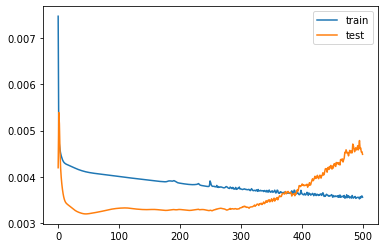

In [28]:
# fit network
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.clf()
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
pyplot.savefig('loss.png')
pyplot.close('all')

In [29]:
yhat

NameError: name 'yhat' is not defined

In [30]:
from sklearn.metrics import mean_squared_error
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual - observed data
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
#rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse = Measures.rmse(inv_yhat,inv_y)
mape = Measures.mape(inv_yhat,inv_y)
smape = Measures.smape(inv_yhat,inv_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test SMAPE: %.3f' % smape)

Test RMSE: 71.664
Test MAPE: 61.181
Test SMAPE: 16.463


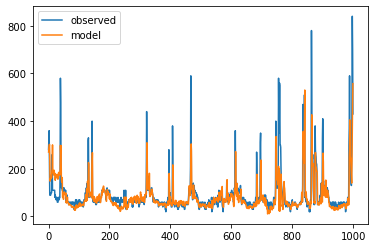

In [31]:
# plot baseline and predictions
pyplot.clf()
pyplot.plot(inv_y[0:1000], label="observed")
pyplot.plot(inv_yhat[0:1000], label="model")
pyplot.legend()
pyplot.show()
#pyplot.savefig('test_and_train.png')
pyplot.close('all')